# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana0700s2"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(4927, 32, 32, 3)
(4927, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(16, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
616/616 [==============================] - 10s 17ms/step - loss: 0.1255 - accuracy: 0.8740 - val_loss: 0.0153 - val_accuracy: 0.9736
Epoch 2/30
616/616 [==============================] - 12s 20ms/step - loss: 0.0167 - accuracy: 0.9665 - val_loss: 0.0087 - val_accuracy: 0.9777
Epoch 3/30
616/616 [==============================] - 14s 22ms/step - loss: 0.0108 - accuracy: 0.9714 - val_loss: 0.0073 - val_accuracy: 0.9797
Epoch 4/30
616/616 [==============================] - 13s 21ms/step - loss: 0.0068 - accuracy: 0.9750 - val_loss: 0.0035 - val_accuracy: 0.9858
Epoch 5/30
616/616 [==============================] - 13s 21ms/step - loss: 0.0050 - accuracy: 0.9807 - val_loss: 0.0033 - val_accuracy: 0.9828
Epoch 6/30
616/616 [==============================] - 13s 22ms/step - loss: 0.0039 - accuracy: 0.9827 - val_loss: 0.0032 - val_accuracy: 0.9706
Epoch 7/30
616/616 [==============================] - 13s 22

### Step 1: Learing result
 
* Visualization of the training and validation results

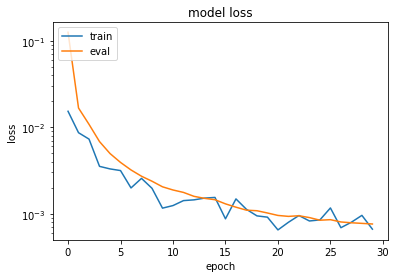

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 160
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/160
616/616 [==============================] - 14s 22ms/step - loss: 0.0491 - accuracy: 0.9407 - val_loss: 0.0114 - val_accuracy: 0.9716
Epoch 2/160
616/616 [==============================] - 14s 22ms/step - loss: 0.0104 - accuracy: 0.9728 - val_loss: 0.0095 - val_accuracy: 0.9848
Epoch 3/160
616/616 [==============================] - 15s 24ms/step - loss: 0.0069 - accuracy: 0.9809 - val_loss: 0.0047 - val_accuracy: 0.9838
Epoch 4/160
616/616 [==============================] - 14s 23ms/step - loss: 0.0049 - accuracy: 0.9817 - val_loss: 0.0046 - val_accuracy: 0.9909
Epoch 5/160
616/616 [==============================] - 14s 23ms/step - loss: 0.0042 - accuracy: 0.9842 - val_loss: 0.0080 - val_accuracy: 0.9838
Epoch 6/160
616/616 [==============================] - 14s 23ms/step - loss: 0.0036 - accuracy: 0.9844 - val_loss: 0.0030 - val_accuracy: 0.9848
Epoch 7/160
616/616 [==============================] - 15s 24ms/step - loss: 0.0033 - accuracy: 0.9876 - val_loss: 0.0028 - val_ac

616/616 [==============================] - 15s 24ms/step - loss: 8.1064e-04 - accuracy: 0.9939 - val_loss: 6.7468e-04 - val_accuracy: 0.9980
Epoch 57/160
616/616 [==============================] - 14s 23ms/step - loss: 8.0994e-04 - accuracy: 0.9947 - val_loss: 7.6347e-04 - val_accuracy: 0.9868
Epoch 58/160
616/616 [==============================] - 14s 23ms/step - loss: 7.6378e-04 - accuracy: 0.9959 - val_loss: 7.8043e-04 - val_accuracy: 0.9838
Epoch 59/160
616/616 [==============================] - 14s 23ms/step - loss: 7.7591e-04 - accuracy: 0.9931 - val_loss: 7.5638e-04 - val_accuracy: 0.9899
Epoch 60/160
616/616 [==============================] - 14s 23ms/step - loss: 7.5305e-04 - accuracy: 0.9937 - val_loss: 0.0010 - val_accuracy: 0.9899
Epoch 61/160
616/616 [==============================] - 14s 23ms/step - loss: 7.6746e-04 - accuracy: 0.9933 - val_loss: 7.6887e-04 - val_accuracy: 0.9919
Epoch 62/160
616/616 [==============================] - 15s 24ms/step - loss: 7.7011e-04 - ac

616/616 [==============================] - 15s 24ms/step - loss: 5.8799e-04 - accuracy: 0.9941 - val_loss: 4.6647e-04 - val_accuracy: 0.9970
Epoch 110/160
616/616 [==============================] - 15s 24ms/step - loss: 5.7801e-04 - accuracy: 0.9945 - val_loss: 4.7633e-04 - val_accuracy: 0.9970
Epoch 111/160
616/616 [==============================] - 15s 24ms/step - loss: 5.6922e-04 - accuracy: 0.9955 - val_loss: 5.1747e-04 - val_accuracy: 0.9939
Epoch 112/160
616/616 [==============================] - 15s 24ms/step - loss: 5.6870e-04 - accuracy: 0.9959 - val_loss: 4.7216e-04 - val_accuracy: 0.9959
Epoch 113/160
616/616 [==============================] - 15s 24ms/step - loss: 5.6489e-04 - accuracy: 0.9961 - val_loss: 7.8078e-04 - val_accuracy: 0.9919
Epoch 114/160
616/616 [==============================] - 15s 24ms/step - loss: 5.8685e-04 - accuracy: 0.9953 - val_loss: 5.5947e-04 - val_accuracy: 0.9929
Epoch 115/160
616/616 [==============================] - 15s 24ms/step - loss: 5.948

### Overall Learing results (Step 1 & Step 2)

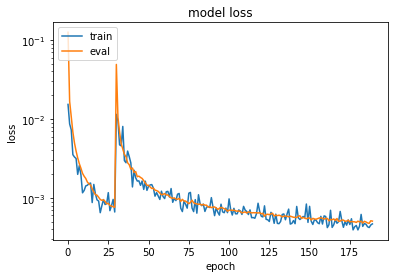

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\5.2_2598_zeiger1_2020-04-29_14-18-02.jpg 0.52 0.5775055956384475 -0.05750559563844748
data_resize_all\5.3_2634_zeiger1_2020-04-29_14-19-02.jpg 0.53 0.598305343044915 -0.06830534304491498
data_resize_all\5.3_2665_zeiger4_2020-04-29_13-41-02.jpg 0.53 0.5825870287079646 -0.05258702870796461
data_resize_all\5.6_2758_zeiger1_2020-04-29_13-00-02.jpg 0.5599999999999999 0.6144971792188241 -0.05449717921882413
data_resize_all\6.2_3048_zeiger1_2020-04-29_11-48-02.jpg 0.62 0.704724262745908 -0.08472426274590805
data_resize_all\6.2_3049_zeiger1_2020-04-29_14-26-02.jpg 0.62 0.692702541651507 -0.07270254165150702
data_resize_all\6.3_3120_zeiger1_2020-04-29_13-06-02.jpg 0.63 0.6968080924706109 -0.06680809247061092
data_resize_all\6.4_3194_zeiger1_2020-04-29_14-27-02.jpg 0.64 0.7129128816780979 -0.07291288167809784
data_resize_all\6.6_3288_zeiger1_2020-04-29_14-28-02.jpg 0.6599999999999999 0.7370589664319269 -0.077058966431927
data_resize_all\6.7_3341_zeiger1_2020-04-29_14-29-02.jpg 0.

## Results

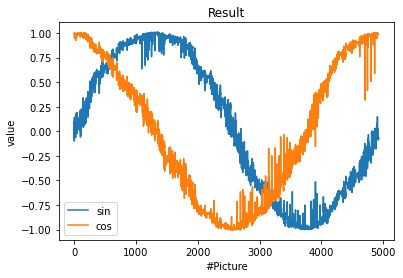

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

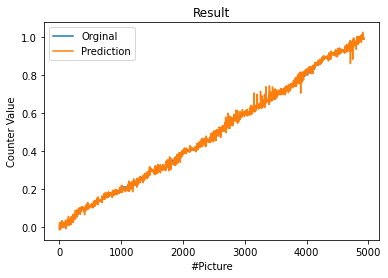

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

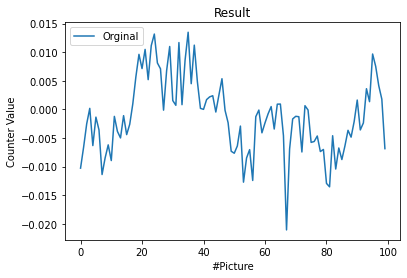

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

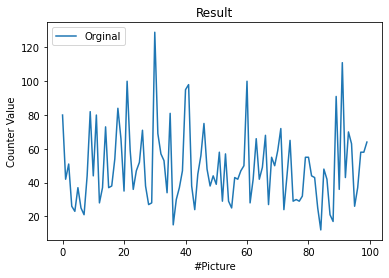

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

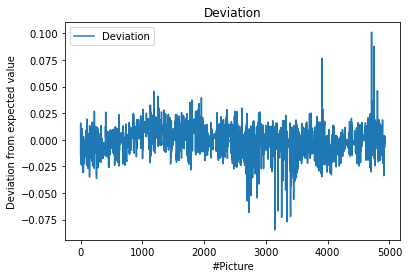

[-0.0007  0.0119 -0.0847  0.1011]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

134180

In [15]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 32, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter2.inference_input_type = tf.int8  # or tf.uint8
converter2.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

41936